In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

## Solving the System of Equations

$\ddot{r} = - g$

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 =  -g$

In [238]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, g = 9.8,  dt = 1.0, target_alt = 2.0, 
                 thrust_gs= 1.5, verbose = False, 
                 record_history = True, record_rate = 100):
        
        super(UniformGravity, self).__init__()
        self.record_rate = record_rate
        self.max_thrust = g*1.5
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-self.max_thrust]), 
                                           high=np.array([self.max_thrust]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0]), 
                                                high=np.array([10**9,10**9]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # setting the target altitude in natural units
        self.target_alt = target_alt
        
        self.dt = dt
        self.g = g
        
        self.max_time = 100.
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = 1.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0

        self.elapsed_time = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r,self.r_dot]])
        
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        
        # actions segragation
        thrust = np.clip(action[0], -self.max_thrust, self.max_thrust)

        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory,[[self.r,self.r_dot]],axis=0)
        
        # reward 1 for every step not done, encouraging staying above ground
        # plus a penalty for every step not near the target altitude
        reward = 1.0 
        
        if (self.r - self.target_alt)**2 < (0.1)**2 and (self.r_dot)**2 < (0.001)**2:
            reward += 100.0
        
        # set if at the terminal state
        done = False
        
        # test for terminal state
        if ((self.r <= 1.0) | 
            (self.r > self.target_alt*3.0) | 
            (self.elapsed_time > self.max_time)):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

## Example Policy

In [221]:
env = UniformGravity(dt = 0.1, verbose=True, target_alt = 1.75)

C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [222]:
env.reset()

for t in range(20):
    if t < 8:
        a = [11.0]
    elif t < 8.5:
        a = [-1.0]
    else:
        a = [9.8]
        
    env.step(a)

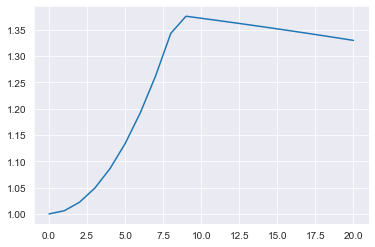

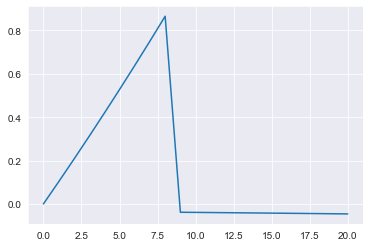

In [223]:
plt.plot(env.trajectory[:,0])
plt.show();

plt.plot(env.trajectory[:,1])
plt.show();

In [224]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v

In [242]:
HIDDEN_SIZE = 128

class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, act_size)
        )

    def forward(self, x):
        return (9.8 + self.net(x))


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + act_size, HIDDEN_SIZE//2),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE//2, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

In [239]:
class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True, ou_mu=0.0, ou_teta=0.15, ou_sigma=0.2, ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if self.ou_enabled and self.ou_epsilon > 0:
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta * (self.ou_mu - a_state)
                a_state += self.ou_sigma * np.random.normal(size=action.shape)

                action += self.ou_epsilon * a_state
                new_a_states.append(a_state)
        else:
            new_a_states = agent_states

        return actions, new_a_states

In [252]:
GAMMA = 0.99
BATCH_SIZE = 512
LEARNING_RATE = 1e-7
REPLAY_SIZE = 100000
REPLAY_INITIAL = 5000

TEST_ITERS = 1000

device = torch.device("cuda")

env = UniformGravity(dt = 0.2, verbose=True, target_alt = 1.5, record_history = False)
test_env =  UniformGravity(dt = 0.2, verbose=True, target_alt = 1.5, record_history = False)

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
crt_net = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
print(act_net)
print(crt_net)
tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)


agent = AgentDDPG(act_net, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

frame_idx = 0
best_reward = None

DDPGActor(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
DDPGCritic(
  (obs_net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
  )
  (out_net): Sequential(
    (0): Linear(in_features=129, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [253]:
while True:
    frame_idx += 1
    buffer.populate(1)
    #rewards_steps = exp_source.pop_rewards_steps()

    #if rewards_steps:
    #    rewards, steps = zip(*rewards_steps)
    #    tb_tracker.track("episode_steps", steps[0], frame_idx)
    #    tracker.reward(rewards[0], frame_idx)

    if len(buffer) < REPLAY_INITIAL:
        continue

    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = \
        unpack_batch_ddqn(batch, device)

    # train critic
    crt_opt.zero_grad()

    q_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)
    q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
    q_last_v[dones_mask] = 0.0
    q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA

    critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
    critic_loss_v.backward()
    crt_opt.step()

    # train actor
    act_opt.zero_grad()

    cur_actions_v = act_net(states_v)
    actor_loss_v = -crt_net(states_v, cur_actions_v)
    actor_loss_v = actor_loss_v.mean()

    actor_loss_v.backward()
    act_opt.step()

    tgt_act_net.alpha_sync(alpha=1 - 1e-4)
    tgt_crt_net.alpha_sync(alpha=1 - 1e-4)

    if frame_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(act_net, test_env, device=device)
        print("Test done in %.2f sec, reward %.3f, steps %d" % (
            time.time() - ts, rewards, steps))

        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
            best_reward = rewards

Test done in 0.30 sec, reward 68.000, steps 68
Test done in 0.31 sec, reward 72.000, steps 72
Best reward updated: 68.000 -> 72.000
Test done in 0.33 sec, reward 77.000, steps 77
Best reward updated: 72.000 -> 77.000
Test done in 0.36 sec, reward 84.000, steps 84
Best reward updated: 77.000 -> 84.000
Test done in 0.45 sec, reward 94.000, steps 94
Best reward updated: 84.000 -> 94.000
Test done in 0.47 sec, reward 111.000, steps 111
Best reward updated: 94.000 -> 111.000
Test done in 0.76 sec, reward 174.000, steps 174
Best reward updated: 111.000 -> 174.000
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.01 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1.000, steps 1
Test done in 0.00 sec, reward 1

KeyboardInterrupt: 

In [247]:
actions_v

tensor([[12.0776],
        [12.8089],
        [ 9.5598],
        [ 9.9846],
        [ 9.9499],
        [11.7843],
        [11.1153],
        [10.7523],
        [10.1633],
        [ 9.9043],
        [10.9506],
        [11.6000],
        [11.9142],
        [10.7239],
        [11.0230],
        [10.0192],
        [10.5552],
        [ 9.5799],
        [10.5428],
        [ 9.9791],
        [12.5599],
        [10.4331],
        [13.1061],
        [10.9609],
        [12.0768],
        [11.1231],
        [12.2605],
        [10.5782],
        [10.0603],
        [10.4400],
        [10.4078],
        [10.4355],
        [11.9305],
        [10.1870],
        [10.2854],
        [10.7950],
        [10.7211],
        [10.9850],
        [10.3204],
        [10.0549],
        [10.3763],
        [10.2349],
        [ 9.7315],
        [10.6253],
        [10.0566],
        [10.3816],
        [10.1425],
        [12.3512],
        [ 9.7897],
        [12.5365],
        [10.6876],
        [11.0878],
        [13.

In [248]:
rewards = 0.0
steps = 0
count = 10

trajectories = []
trajectories_act = []

# play count episodes
for _ in range(count):
    state = env.reset()
    traj = [state]
    traj_act = []
    print('----')
    while True:
        obs_v = ptan.agent.float32_preprocessor([state])
        obs_v = obs_v.to(device)
        mu_v = act_net(obs_v)
        action = mu_v.squeeze(dim=0).data.cpu().numpy()
        state, reward, done, _ = env.step(action)
        traj.append(state)
        traj_act.append(action[0])
        print('\t',action)
        rewards += reward
        steps += 1
        if done:
            break
    trajectories.append(traj)
    trajectories_act.append(traj_act)

trajectories = np.array(trajectories)
trajectories_act = np.array(trajectories_act)
(rewards / count, steps / count)

----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]
----
	 [10.756757]
	 [10.997228]
	 [11.573501]
	 [12.650253]
	 [14.556614]


(5.0, 5.0)

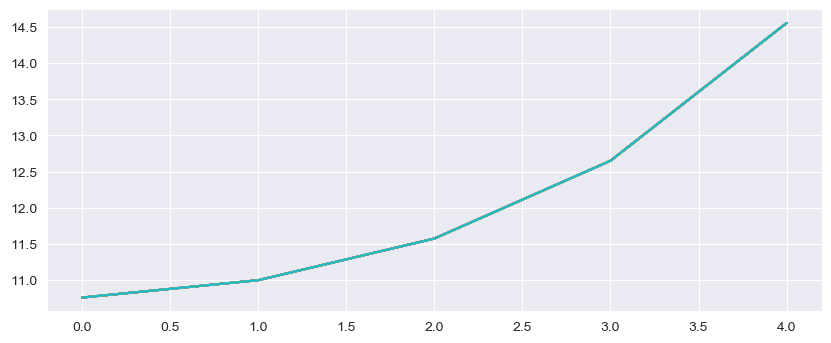

In [249]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories_act.T );

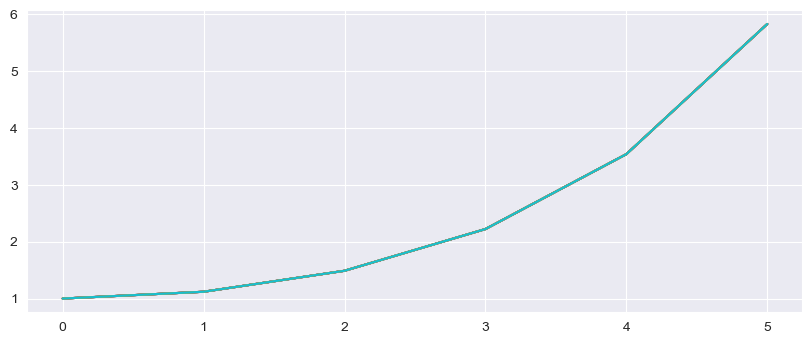

In [250]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories[:,:,0].T );

## Vanilla Policy Gradient Method

In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 8

class PGN(nn.Module):
    def __init__(self, in_size, a_size):
        super(PGN,self).__init__()
        
        self.actions_mu = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, a_size)
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, a_size)
        )
        
        self.values =  nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def __call__(self, x):
        return (9.8+self.actions_mu(x)), torch.abs(self.actions_var(x)), self.values(x)
    
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()[0]
        sigma = torch.sqrt(var_v).data.cpu().numpy()[0]
        actions = np.random.normal(mu, sigma)
        return actions

using device:  cuda


In [210]:
def compute_discounted_rewards(epi_rewards):
    batch_R = []
    R = 0.0
    for r in reversed(epi_rewards):
        R = r + GAMMA*R
        batch_R.append(R)
    q = list(reversed(batch_R))
    return q
    #q_mean = np.mean(q)
    #return [q_i - q_mean for q_i in q]
    
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [211]:
net = PGN(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
print(net)

agent = AgentA2C(net, device=device)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

PGN(
  (actions_mu): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (actions_var): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (values): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [215]:
states = env.reset()

states_v = ptan.agent.float32_preprocessor([states])
states_v = states_v.to(device)

mu_v, var_v, vals_v = net(states_v)
mu = mu_v.data.cpu().numpy()[0]
sigma = torch.sqrt(var_v).data.cpu().numpy()[0]

actions = np.random.normal(mu, sigma)
actions

array([10.62289353])

In [216]:
ENTROPY_BETA = 1e-2

batch_states, batch_actions, batch_R = [], [], []
batch_rewards = []

total_rewards = collections.deque(maxlen=100)
batch_episodes = 0
done_episodes = 0
step_idx = 0
episode_length = 0

state = env.reset()

while True:
    step_idx += 1
    episode_length += 1
    
    # select an action based on the current policy
    a = agent([state])
    new_state, r, done, _ = env.step(a)

    # store the experience
    batch_states.append(state)
    batch_actions.append(a)
    batch_rewards.append(r)

    if done:        
        discounted_rewards = compute_discounted_rewards(batch_rewards)
        batch_R.extend(discounted_rewards)
        
        new_reward = np.sum(batch_rewards)
        total_rewards.append(new_reward)
        
        batch_rewards.clear()
        batch_episodes += 1
        done_episodes += 1
        
        state = env.reset()
        
        mean_rewards = np.mean(total_rewards)
        if done_episodes % 100 == 0:
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d, epi_length: %d" % (
                        step_idx, new_reward, mean_rewards, done_episodes, episode_length))
        
        if mean_rewards > np.inf:
            print('Solved in %d steps and in %d eps'%(step_idx, done_episodes))
            break
        
        episode_length = 0
    else:
        state = new_state


    if batch_episodes < BATCH_SIZE:
        continue
    
    # done acquiring events, time to train
    batch_episodes = 0    
    
    optimizer.zero_grad()
    
    batch_state_v = torch.FloatTensor(batch_states).to(device)
    batch_actions_v = torch.FloatTensor(batch_actions).to(device)
    batch_R_v = torch.FloatTensor(batch_R).to(device)
    
    mu_v, var_v, values_v = net(batch_state_v)
    
    loss_value_v = F.mse_loss(values_v.squeeze(-1), batch_R_v)
    
    adv_v = batch_R_v.unsqueeze(dim=-1) - values_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, batch_actions_v)
    loss_policy_v = -log_prob_v.mean()
    
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v
    loss_v.backward()
    
    optimizer.step()
    
    batch_states.clear()
    batch_actions.clear()
    batch_R.clear()

3208: reward: 924.74, mean_100: 182520.54, episodes: 100, epi_length: 33
6505: reward: 1360.04, mean_100: 16657188.67, episodes: 200, epi_length: 33
9644: reward: 3240078.09, mean_100: 34779974.72, episodes: 300, epi_length: 33
12979: reward: 1012.12, mean_100: 26633544.08, episodes: 400, epi_length: 33
16334: reward: 1133.30, mean_100: 30583.74, episodes: 500, epi_length: 36
19656: reward: 7605.88, mean_100: 1646142.86, episodes: 600, epi_length: 34
22826: reward: 3950.58, mean_100: 57032.13, episodes: 700, epi_length: 33
26071: reward: 1708.26, mean_100: 80841.64, episodes: 800, epi_length: 34
29187: reward:   1.77, mean_100: 49334.55, episodes: 900, epi_length: 1
32325: reward: 9086.08, mean_100: 65535.17, episodes: 1000, epi_length: 32
35432: reward:   1.77, mean_100: 34011.09, episodes: 1100, epi_length: 1
38501: reward: 1265.61, mean_100: 152060.89, episodes: 1200, epi_length: 34
41693: reward: 2172.71, mean_100: 1659297.72, episodes: 1300, epi_length: 35
44885: reward: 2421244.1

KeyboardInterrupt: 

In [217]:
rewards = 0.0
steps = 0
count = 10

trajectories = []
trajectories_act = []

# play count episodes
for _ in range(count):
    state = env.reset()
    traj = [state]
    traj_act = []
    print('----')
    while True:
        obs_v = ptan.agent.float32_preprocessor([state])
        obs_v = obs_v.to(device)
        mu_v,_,_ = net(obs_v)
        action = mu_v.squeeze(dim=0).data.cpu().numpy()
        state, reward, done, _ = env.step(action)
        traj.append(state)
        traj_act.append(action[0])
        #print('\t',action)
        rewards += reward
        steps += 1
        if done:
            break
    trajectories.append(traj)
    trajectories_act.append(traj_act)

trajectories = np.array(trajectories)
trajectories_act = np.array(trajectories_act)
(rewards / count, steps / count)

----
----
----
----
----
----
----
----
----
----


(5507.863373499289, 33.0)

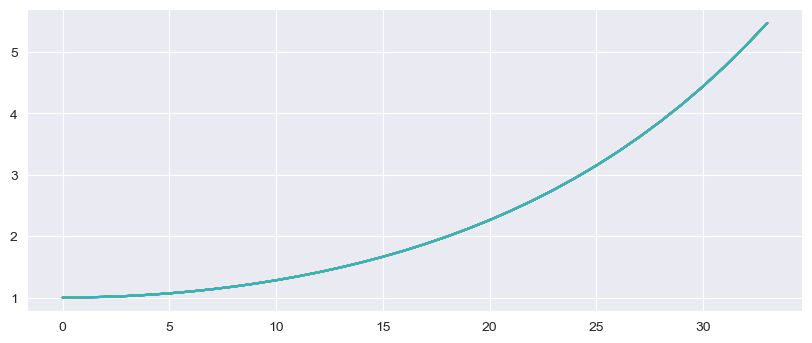

In [218]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories[:,:,0].T );

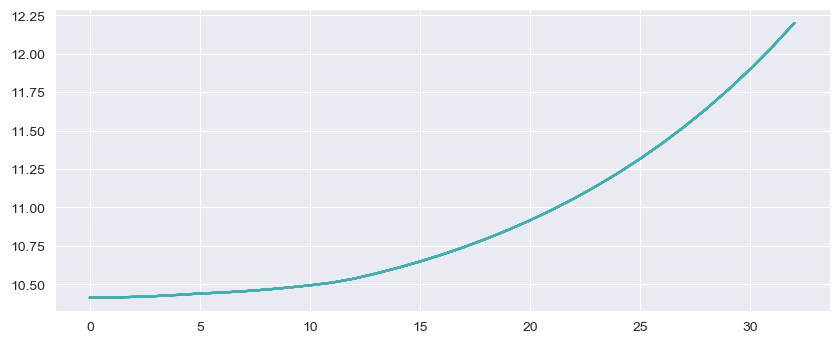

In [219]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories_act.T );